Alzheimer’s disease (AD) is a significant factor in morbidity, ranked fifth among causes of death by the World Health Organization (WHO) 
AD ,the most widespread reason for dementia in the elderly, is a chronic degenerative disease with progressive loss of intellectual function. The cognitive decline is characterized by gradual disappearance of healthy nerve cells in the cerebral cortex, especially in the frontal and medial temporal regions of the brain.. The presence of amyloid plaques and neurofibrillary tangles in the brain are characteristic features of this disease. Although the cause of AD is poorly understood, the risk factors include genetics, history of head injury, depression, and hypertension. The onset of the disease is subtle and usually occurs when over 65 years of age. The first noticeable changes include difficulty in short term memory, disorientation, lack of self-care, behavioral changes, depression, anxiety, and problems with language. It is generally accepted that Alzheimer’s disease has a gradual and irreversible progression. In the terminal stages of the disease, the patient may lose ability to perceive, think, speak or move, ultimately leading to loss of bodily functions and then finally to death. The progression of the disease may take from 3 to 9 years , or even longer .


### Task of this Notebook  :

Build a model (classifier) able to correctly classify the different phases of Alzheimer disease , starting from their Structural Magnetic Resonance Imaging (MRI) images using convolutional Neural Networks and  Transfer Learning. 

Transfer Learning  is an excellence approach for problems where there isn't a large amount of data. Using pre-trained models helps us increase our accuracy, since these models are trained on datasets with millions of images. Adding our own fully connected layers to adapt these models to this particular problem is the final step for this procedure. 




### Importing main libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import os.path
from   os import path
import shutil
import tensorflow as tf
import itertools
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
from keras.layers import GlobalAveragePooling2D


from keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet169,DenseNet121,InceptionV3, Xception, ResNet101
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Importing data

DATASET

For this tutorial we'll use the data made availble here: Kaggle Azlheimer's Dataset. The dataset consists of 6400 bidimensional B&W images with a standard shape of (208,176) saved into 4 different folders, each containing a sample of data for each category to identify:


*   NonDemented
*   VeryMildDemented
*   MildDemented
*   ModerateDemented

To import these data, Keras provides a strong tool: the ImageGenerator function that help in importing and preprocessing phases. 

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belbellajwiame","key":"08aa0ba7aaf87dd1e1e5388cd4184177"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!mkdir /content/alzheimers-dataset
!cp alzheimers-dataset-4-class-of-images.zip /content/alzheimers-dataset
%cd /content/alzheimers-dataset
!unzip  alzheimers-dataset-4-class-of-images.zip 
%cd ..

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem219.jpg  
  inflating: Alzheimer_s D

Determine the Number of Images for each class

The dataset provided is split into train and test batches consisting of 4 classes. The function below loops through each folder and displays the number of images of each class

In [4]:
# Constants
FOLDERS     = ['train','val','test']
DIR_INPUT   = '/content/alzheimers-dataset/Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    normal,verymild,mild,moderate =0,0,0,0
    
    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder','NonDem','VeryMilddem','MildDem','Moderatedem',
                                                        'NonDem %','VeryMildDem %','MildDeme %','Moderatedem %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in FOLDERS:
        for dirname,_, filenames in os.walk(os.path.join(path,folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal+=1
                if "VeryMildDemented" in dirname:
                    verymild+=1
                if 'MildDemented' in dirname:
                    mild+=1
                if 'ModerateDemented' in dirname:
                    moderate+=1
                    
        # calculate total and percentages            
        total = normal+verymild+mild+moderate
        if total >0:
            n  = round(normal/total,2)*100
            vm = round(verymild/total,2)*100
            m  = round(mild/total,2)*100
            mo =round(moderate/total,2)*100
        else:
            n,vm,m,mo = 0,0,0,0
        
        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(folder,normal,verymild,mild,moderate,n,vm,m,mo))
        normal,verymild,mild,moderate =0,0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS)

folder   NonDem   VeryMilddem MildDem Moderatedem NonDem %  VeryMildDem % MildDeme % Moderatedem %
--------------------------------------------------------------------------------------------------
train      2560       1792    2509          52     37.0       26.0     36.0          1.0
val           0          0       0           0        0          0        0            0
test        640        448     627          12     37.0       26.0     36.0          1.0


in this case (supervised learning) we verify if each label  is equally represented, namely if the dataset can be considered balanced. The underepresentation of one or more classes could be a potential problem for the model, leading to poor performances. In this case the daset is strongly unmbalanced, with 3200 images in the Non-Demented class, 2240 images in the VeryMild-Demented class, 896 in the Mild-Demented class and just 64 images in the Moderate-Demented class. 

### Preprocessing DATA(data augmentation)

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '../content/alzheimers-dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 60)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../content/alzheimers-dataset/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 60)

Found 254 images belonging to 4 classes.


In [ ]:
labels = final_data['label']

### Data Visualization




View sample images from the generators 


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


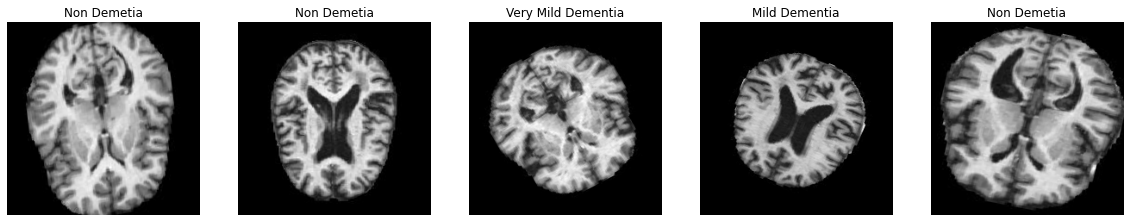

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

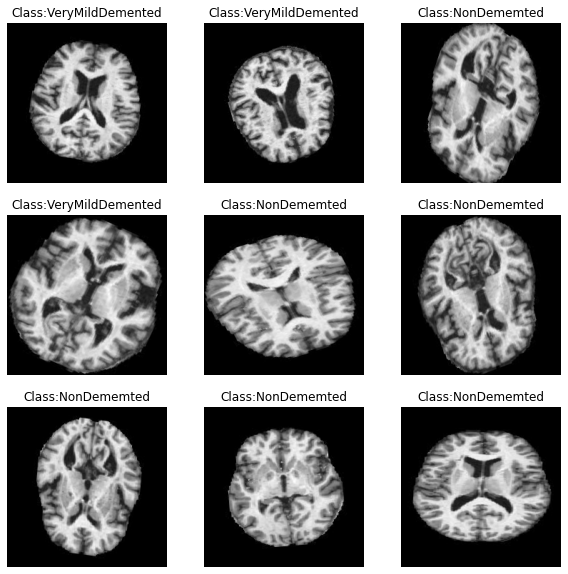

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

## Building the Alzheimer Stages Classifier

Base Model: Transfer Learning

  •	Load pre-trained model(DenseNet169, VGG19, VGG16)

  •	Freeze the weights in the base model

  •	Add top layer for classification 

  •	Add callbacks for early stopping and modelcheckpoint
  
  •	Train the model with each base models: DenseNet169, VGG19, VGG16

  •	Evaluate the model 



### Model Initialization
Importing pre-trained model and adding dense layers

To select a base model for transfer learning a simple model was trained using DenseNet169, VGG16 and VGG19 . All pre-trained weights were frozen and the AUC for the training set was calculated. The image dataset is unbalanced with unequal examples of classes. Accuracy would be biased towards the highest frequency class, so AUC was selected as an alternative model performance metric.

In [7]:
#we import DenseNet169 model without its last layer
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")
#DenseNet-169 was chosen because despite having a depth of 169 layers it is relatively low in parameters compared to other models
#and the architecture handles the vanish gradient problem well.

51879936/51877672 [==============================] - 0s 0us/step


The architecture of DenseNet169 model is as follow: 

In [9]:
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

### Freezing layers


In [8]:
#Since we do not have a large dataset, we will set all the base model's parameters as non trainable and use the pre-trained network weights as initialisers
for layer in base_model.layers:
    layer.trainable=False

### build model


In [ ]:
#Next we make a model based on base_model, add some layers and softmax layers.
# Start a new Keras Sequential model.
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
# Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data 
model.add(Dropout(0.5))
# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
model.add(Flatten())
model.add(BatchNormalization())
# Add a dense (aka. fully-connected) layer.
# This is for combining features that the Densenet169 model has recognized in the image.
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Add the final layer for the actual classification.
model.add(Dense(4,activation='softmax'))

In [ ]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1664)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1664)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1664)              6656      
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              3409920   
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)             

In [ ]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable()

True:	densenet169
True:	dropout
True:	flatten
True:	batch_normalization
True:	dense
True:	batch_normalization_1
True:	activation
True:	dropout_1
True:	dense_1
True:	batch_normalization_2
True:	activation_1
True:	dropout_2
True:	dense_2


### compile model


In [ ]:
# We compile the models using adam as optimizer, categorical cross entropy as loss function and accuracy as evaluation metric
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - 69s 2s/step - loss: 1.5848 - auc: 0.7267 - val_loss: 6.0041 - val_auc: 0.6961

Epoch 00001: val_auc improved from -inf to 0.69606, saving model to ./best_weights.hdf5
Epoch 2/500
33/33 [==============================] - 49s 1s/step - loss: 1.0751 - auc: 0.8357 - val_loss: 1.5557 - val_auc: 0.8229

Epoch 00002: val_auc improved from 0.69606 to 0.82292, saving model to ./best_weights.hdf5
Epoch 3/500
33/33 [==============================] - 49s 1s/step - loss: 1.0028 - auc: 0.8464 - val_loss: 1.0668 - val_auc: 0.8570

Epoch 00003: val_auc improved from 0.82292 to 0.85704, saving model to ./best_weights.hdf5
Epoch 4/500
33/33 [==============================] - 49s 1s/step - loss: 0.9859 - auc: 0.8531 - val_loss: 0.8420 - val_auc: 0.8776

Epoch 00004: val_auc improved from 0.85704 to 0.87762, saving model to ./best_weights.hdf5
Epoch 5/500
33/33 [==============================] - 50s 1s/step - loss: 0.8765 - auc: 0.8726 - val_loss: 0.817

### model evaluation

In model evaluation functions was used throughout the analysis to plot training metrics. It plots loss by epochs, AUC by epochs, and the four-class confusion matrix with the training AUC metric. AUC was chosen as the performance metric instead of accuracy due to the class imbalance in the training images.


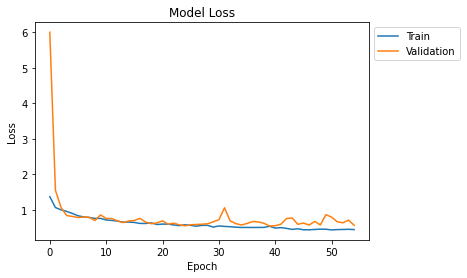

In [ ]:

# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


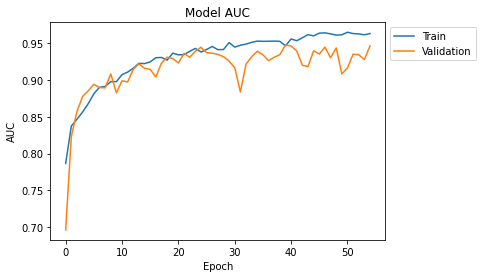

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [40]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['val_auc']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_auc']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.gca().set_ylim(0, 1)

    plt.show()

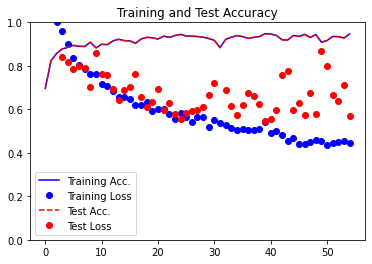

In [ ]:
plot_training_history(model_history)

In [45]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

10/10 [==============================] - 5s 446ms/step - loss: 1.0428 - auc: 0.8881


In [10]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '../content/alzheimers-dataset/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 60)

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 7s 745ms/step - loss: 1.0428 - auc: 0.8881


[1.0427947044372559, 0.8880622386932373]

In [ ]:
result = model.evaluate(test_dataset)

10/10 [==============================] - 5s 444ms/step - loss: 1.0428 - auc: 0.8881


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


99.57 % chances are there that the image is NonDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


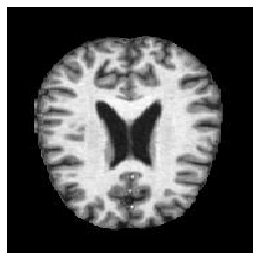

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

88.7 % chances are there that the image is MildDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


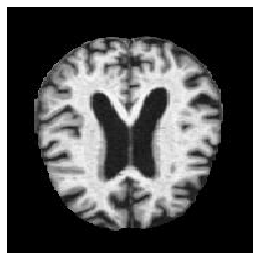

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.85 % chances are there that the image is ModerateDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


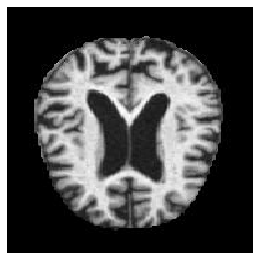

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

97.01 % chances are there that the image is VeryMildDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


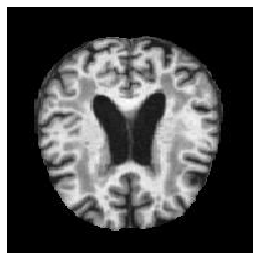

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [48]:
cls_train = valid_dataset.classes
cls_test = valid_dataset.classes
batch_size = 20
steps_test = valid_dataset.n / batch_size
steps_test


12.7

In [ ]:
class_names = list(valid_dataset.class_indices.keys())
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
y_pred = model.predict(valid_dataset, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
print_confusion_matrix(cls_pred)

Confusion matrix:
[[  0   0  35   0]
 [  0   0   2   0]
 [  0   0 127   1]
 [  0   0  85   4]]
(0) MildDemented
(1) ModerateDemented
(2) NonDemented
(3) VeryMildDemented


In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 88.81%



### FINE TUNING


In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original pre-trained model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the pre-trained model that may either distort its weights or cause overfitting to the new dataset.

But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the VGG16 model as well. We call this Fine-Tuning.

It is a bit unclear whether Keras uses the trainable boolean in each layer of the original pre-trained model or if it is overrided by the trainable boolean in the "meta-layer" we call conv_layer. So we will enable the trainable boolean for both conv_layer and all the relevant layers in the original pre-trained model.

In [ ]:
#Unfreeze layers
base_model.trainable = True

In [ ]:
for layer in base_model.layers:
    
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
   
    layer.trainable = trainable

In [ ]:

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
69/69 [==============================] - 83s 932ms/step - loss: 1.6316 - auc: 0.7043 - val_loss: 48.1820 - val_auc: 0.4252

Epoch 00001: val_auc improved from -inf to 0.42520, saving model to ./best_weights.hdf5
Epoch 2/10
69/69 [==============================] - 60s 868ms/step - loss: 1.3433 - auc: 0.7601 - val_loss: 3.7817 - val_auc: 0.5623

Epoch 00002: val_auc improved from 0.42520 to 0.56228, saving model to ./best_weights.hdf5
Epoch 3/10
69/69 [==============================] - 60s 868ms/step - loss: 1.0073 - auc: 0.8225 - val_loss: 1.9769 - val_auc: 0.3521

Epoch 00003: val_auc did not improve from 0.56228
Epoch 4/10
69/69 [==============================] - 60s 865ms/step - loss: 0.9522 - auc: 0.8331 - val_loss: 1.2166 - val_auc: 0.8241

Epoch 00004: val_auc improved from 0.56228 to 0.82410, saving model to ./best_weights.hdf5
Epoch 5/10
69/69 [==============================] - 60s 866ms/step - loss: 0.8705 - auc: 0.8520 - val_loss: 2.8708 - val_auc: 0.7693

Epoch 000

### Fine tuned model Evaluation

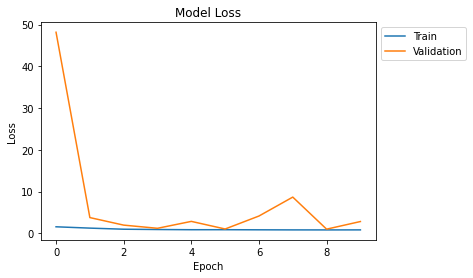

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

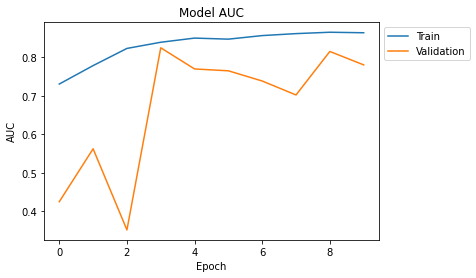

In [ ]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

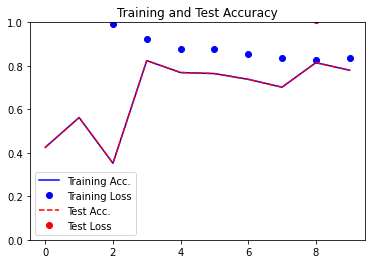

In [ ]:
plot_training_history(model_history)

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 15,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/15
69/69 [==============================] - 82s 919ms/step - loss: 1.5784 - auc: 0.7083 - val_loss: 1.2899 - val_auc: 0.7470

Epoch 00001: val_auc improved from -inf to 0.74695, saving model to ./best_weights.hdf5
Epoch 2/15
69/69 [==============================] - 59s 854ms/step - loss: 1.1489 - auc: 0.7974 - val_loss: 2.1275 - val_auc: 0.5788

Epoch 00002: val_auc did not improve from 0.74695
Epoch 3/15
69/69 [==============================] - 59s 850ms/step - loss: 0.9478 - auc: 0.8227 - val_loss: 4.0868 - val_auc: 0.4586

Epoch 00003: val_auc did not improve from 0.74695
Epoch 4/15
69/69 [==============================] - 59s 857ms/step - loss: 0.8749 - auc: 0.8491 - val_loss: 2.9533 - val_auc: 0.7874

Epoch 00004: val_auc improved from 0.74695 to 0.78744, saving model to ./best_weights.hdf5
Epoch 5/15
69/69 [==============================] - 59s 857ms/step - loss: 0.8732 - auc: 0.8544 - val_loss: 0.9067 - val_auc: 0.8398

Epoch 00005: val_auc improved from 0.78744 to 0.839

### Fine tuned model Evaluation 

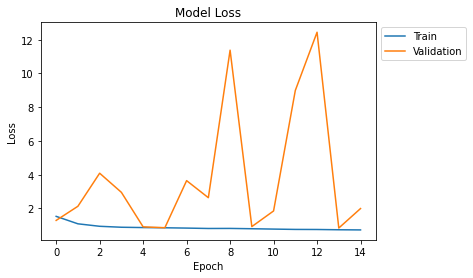

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

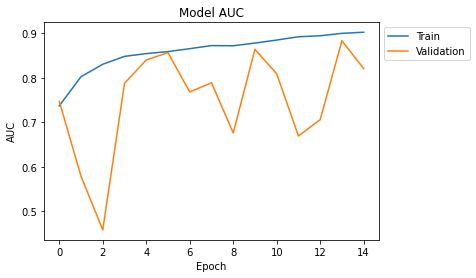

In [ ]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

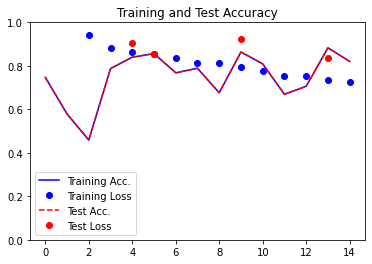

In [ ]:
plot_training_history(model_history)

In [ ]:
result = model.evaluate(valid_dataset, steps=128)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

128/128 [==============================] - 1s 5ms/step - loss: 1.9927 - auc: 0.8204
Test-set classification accuracy: 82.04%


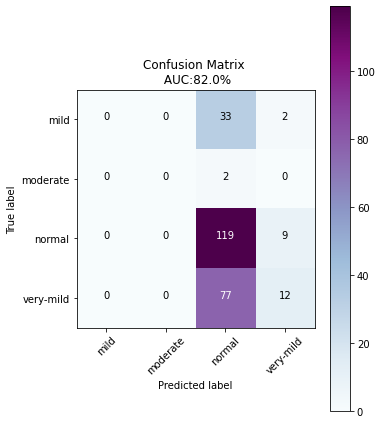

In [ ]:


test_loss, test_metric = model.evaluate(valid_dataset,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
classes=['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)
plt.subplots(figsize=(15,6))
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(c, r, format(cm[r, c], 'd'),
  horizontalalignment="center",
  color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

# *VGG19* pretrained model

In [ ]:

# Loading Model

vgg19model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")
# Freezing Layers

for layer in vgg19model.layers:
    layer.trainable=False

80142336/80134624 [==============================] - 1s 0us/step


The architecture of VGG19 pre-trained model is as follow:

In [ ]:
vgg19model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Building Model

model=Sequential()
model.add(vgg19model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)             

In [ ]:
# Model Compile

METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)
# Defining Callbacks


filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
69/69 [==============================] - 55s 750ms/step - loss: 1.4994 - auc: 0.7403 - val_loss: 1.0383 - val_auc: 0.8166

Epoch 00001: val_auc improved from -inf to 0.81662, saving model to ./best_weights.hdf5
Epoch 2/500
69/69 [==============================] - 51s 733ms/step - loss: 1.1569 - auc: 0.8062 - val_loss: 0.8553 - val_auc: 0.8618

Epoch 00002: val_auc improved from 0.81662 to 0.86178, saving model to ./best_weights.hdf5
Epoch 3/500
69/69 [==============================] - 51s 733ms/step - loss: 1.0168 - auc: 0.8307 - val_loss: 0.8357 - val_auc: 0.8681

Epoch 00003: val_auc improved from 0.86178 to 0.86813, saving model to ./best_weights.hdf5
Epoch 4/500
69/69 [==============================] - 51s 731ms/step - loss: 0.9777 - auc: 0.8357 - val_loss: 0.8265 - val_auc: 0.8694

Epoch 00004: val_auc improved from 0.86813 to 0.86941, saving model to ./best_weights.hdf5
Epoch 5/500
69/69 [==============================] - 52s 757ms/step - loss: 0.9179 - auc: 0.8468 - 

###  Evaluation of model based on VGG19

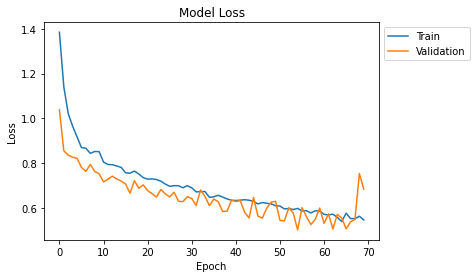

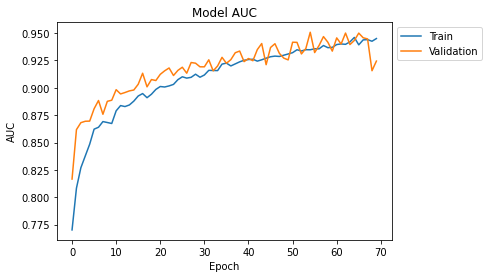

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Summarize history for accuracy
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

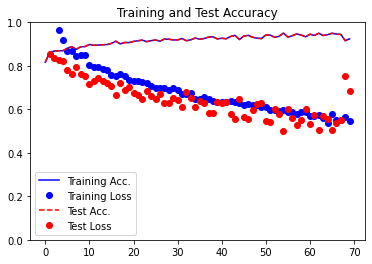

In [ ]:
plot_training_history(model_history)

In [ ]:
result = model.evaluate(valid_dataset, steps=128)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

128/128 [==============================] - 1s 8ms/step - loss: 0.6840 - auc: 0.9244
Test-set classification accuracy: 92.44%


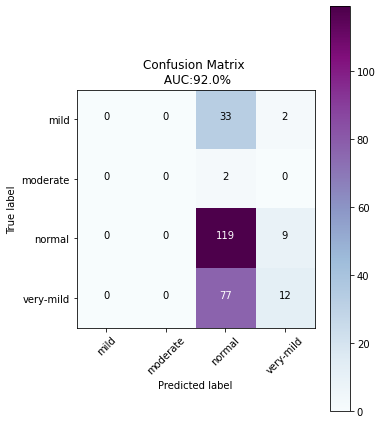

In [ ]:


test_loss, test_metric = model.evaluate(valid_dataset,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
classes=['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)
plt.subplots(figsize=(15,6))
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(c, r, format(cm[r, c], 'd'),
  horizontalalignment="center",
  color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]


### fine tuning

In [ ]:
vgg19model.trainable = True
for layer in vgg19model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
69/69 [==============================] - 60s 828ms/step - loss: 0.8634 - auc: 0.8546 - val_loss: 14465.9941 - val_auc: 0.6623

Epoch 00001: val_auc improved from -inf to 0.66235, saving model to ./best_weights.hdf5
Epoch 2/100
69/69 [==============================] - 57s 823ms/step - loss: 0.8500 - auc: 0.8599 - val_loss: 293388.8750 - val_auc: 0.6693

Epoch 00002: val_auc improved from 0.66235 to 0.66930, saving model to ./best_weights.hdf5
Epoch 3/100
69/69 [==============================] - 57s 822ms/step - loss: 0.8429 - auc: 0.8619 - val_loss: 14.6971 - val_auc: 0.6693

Epoch 00003: val_auc did not improve from 0.66930
Epoch 4/100
69/69 [==============================] - 57s 819ms/step - loss: 0.8555 - auc: 0.8565 - val_loss: 16.6390 - val_auc: 0.6693

Epoch 00004: val_auc did not improve from 0.66930
Epoch 5/100
69/69 [==============================] - 57s 820ms/step - loss: 0.8372 - auc: 0.8672 - val_loss: 3.8259 - val_auc: 0.7277

Epoch 00005: val_auc improved from 

### finetuned model based on VGG19 evaluation 

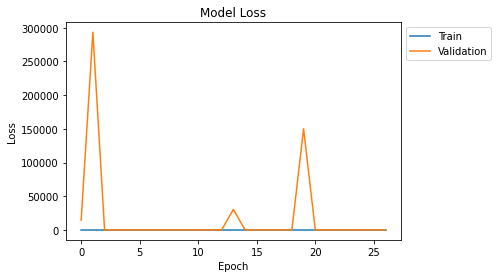

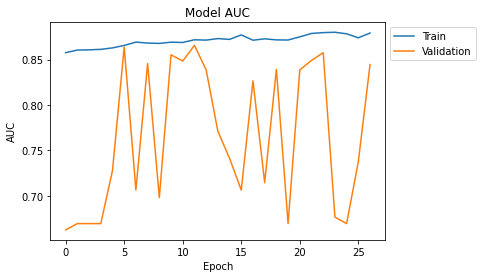

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Summarize history for accuracy
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

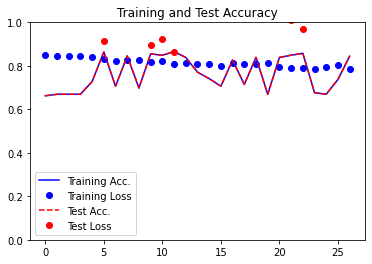

In [ ]:
plot_training_history(model_history)

In [ ]:
result = model.evaluate(valid_dataset, steps=128)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

128/128 [==============================] - 1s 7ms/step - loss: 1.2573 - auc: 0.8444
Test-set classification accuracy: 84.44%


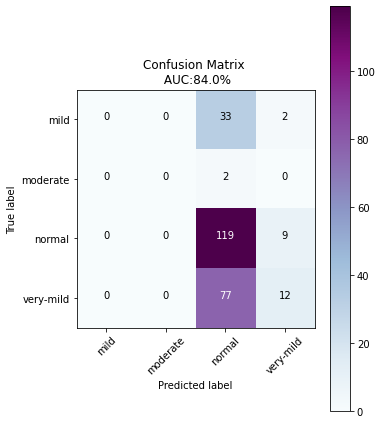

In [ ]:


test_loss, test_metric = model.evaluate(valid_dataset,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
classes=['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)
plt.subplots(figsize=(15,6))
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(c, r, format(cm[r, c], 'd'),
  horizontalalignment="center",
  color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

# VGG16 

In [20]:
vgg16_base = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [21]:
# Freezing Layers

for layer in vgg16_base.layers:
    layer.trainable=False

The architecture of VGG16 pre-trained model is as follow :

In [22]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
# Building Model

modelvgg16=Sequential()
modelvgg16.add(vgg16_base)
modelvgg16.add(GlobalAveragePooling2D())
modelvgg16.add(Dropout(0.5))
modelvgg16.add(Flatten())
modelvgg16.add(BatchNormalization())
modelvgg16.add(Dense(2048,kernel_initializer='he_uniform'))
modelvgg16.add(BatchNormalization())
modelvgg16.add(Activation('relu'))
modelvgg16.add(Dropout(0.5))
modelvgg16.add(Dense(1024,kernel_initializer='he_uniform'))
modelvgg16.add(BatchNormalization())
modelvgg16.add(Activation('relu'))
modelvgg16.add(Dropout(0.5))
modelvgg16.add(Dense(4,activation='softmax'))

the top layer model architecture is summarized in :

In [36]:
modelvgg16.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
batch_normalization_10 (Batc (None, 2048)             

In [37]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

modelvgg16.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [38]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [39]:
modelvgg16_history=modelvgg16.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)


Epoch 1/50
69/69 [==============================] - 48s 676ms/step - loss: 1.6336 - auc: 0.6964 - val_loss: 1.2166 - val_auc: 0.6385

Epoch 00001: val_auc improved from -inf to 0.63847, saving model to ./best_weights.hdf5
Epoch 2/50
69/69 [==============================] - 46s 669ms/step - loss: 1.3067 - auc: 0.7815 - val_loss: 1.0159 - val_auc: 0.8277

Epoch 00002: val_auc improved from 0.63847 to 0.82770, saving model to ./best_weights.hdf5
Epoch 3/50
69/69 [==============================] - 46s 666ms/step - loss: 1.1823 - auc: 0.7818 - val_loss: 0.9923 - val_auc: 0.8185

Epoch 00003: val_auc did not improve from 0.82770
Epoch 4/50
69/69 [==============================] - 46s 668ms/step - loss: 1.0501 - auc: 0.8092 - val_loss: 0.9511 - val_auc: 0.8282

Epoch 00004: val_auc improved from 0.82770 to 0.82824, saving model to ./best_weights.hdf5
Epoch 5/50
69/69 [==============================] - 46s 669ms/step - loss: 1.0448 - auc: 0.8062 - val_loss: 0.9353 - val_auc: 0.8319

Epoch 0000

### Model Evaluation :

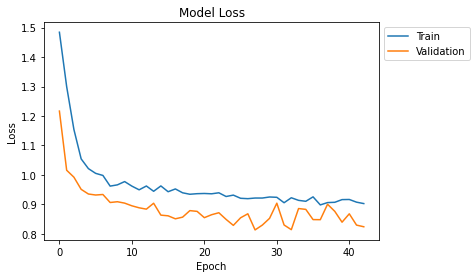

In [41]:
# Summarize history for loss

plt.plot(modelvgg16_history.history['loss'])
plt.plot(modelvgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

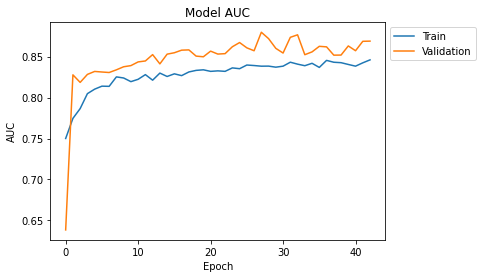

In [42]:
# Summarize history for accuracy

plt.plot(modelvgg16_history.history['auc'])
plt.plot(modelvgg16_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

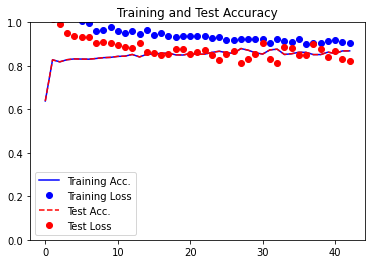

In [43]:
plot_training_history(modelvgg16_history)

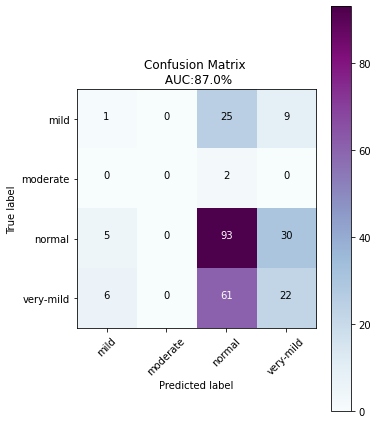

In [52]:


test_loss, test_metric = modelvgg16.evaluate(valid_dataset,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
classes=['mild','moderate','normal','very-mild']
cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)
plt.subplots(figsize=(15,6))
plt.subplot(1,3,3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(c, r, format(cm[r, c], 'd'),
  horizontalalignment="center",
  color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

In [51]:
result = modelvgg16.evaluate(valid_dataset, steps=128)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

128/128 [==============================] - 1s 6ms/step - loss: 0.8241 - auc: 0.8688
Test-set classification accuracy: 86.88%


### fine tuning 

In [56]:
vgg16_base.trainable = True
for layer in vgg16_base.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)


modelvgg16.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)
modelvgg16_history=modelvgg16.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 30,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/30
69/69 [==============================] - 51s 714ms/step - loss: 0.8334 - auc: 0.8607 - val_loss: 0.8540 - val_auc: 0.8582

Epoch 00001: val_auc did not improve from 0.87969
Epoch 2/30
69/69 [==============================] - 49s 710ms/step - loss: 0.8371 - auc: 0.8631 - val_loss: 4.3586 - val_auc: 0.7263

Epoch 00002: val_auc did not improve from 0.87969
Epoch 3/30
69/69 [==============================] - 49s 711ms/step - loss: 0.8205 - auc: 0.8683 - val_loss: 6.4628 - val_auc: 0.7018

Epoch 00003: val_auc did not improve from 0.87969
Epoch 4/30
69/69 [==============================] - 50s 715ms/step - loss: 0.8168 - auc: 0.8650 - val_loss: 1.6795 - val_auc: 0.8229

Epoch 00004: val_auc did not improve from 0.87969
Epoch 5/30
69/69 [==============================] - 49s 719ms/step - loss: 0.8288 - auc: 0.8628 - val_loss: 17.6422 - val_auc: 0.6732

Epoch 00005: val_auc did not improve from 0.87969
Epoch 6/30
69/69 [==============================] - 49s 711ms/step - loss: 0.80

### finetuned model evaluation 

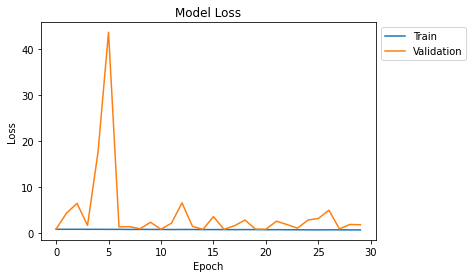

In [57]:
# Summarize history for loss

plt.plot(modelvgg16_history.history['loss'])
plt.plot(modelvgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

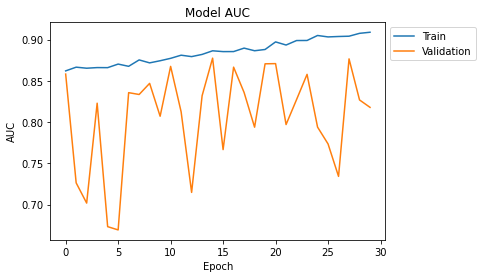

In [58]:
# Summarize history for accuracy

plt.plot(modelvgg16_history.history['auc'])
plt.plot(modelvgg16_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()